# Word Embedding 2 - CBOW

CBOW(Continuous Bag of Words)是一种广泛使用的词嵌入模型，最初是由Mikolov提出。CBOW中由周围词(surrounding words)去预测目标词(target words)。以这个句子为例** the quick brown fox jumps over the lazy dog **，如果窗口长度为2，提取出的样本格式**([context words], target)**，则可以提取出**([the brown], quick)**, **([quick, fox], brown)**,..., **([the dog], lazy)**等训练样本。

<img src="images/cbow_sample.png" style="width:500px;">
<caption><center> **Figure 1**: CBOW sample </center></caption>


这些训练样本就可以输入只有一个隐藏层简单的DNN(Deep Neural Network)中进行训练得出word embedding向量

<img src="images/cbow_model.png" style="width:300px;">
<caption><center> **Figure 1**: CBOW model </center></caption>

输入为context words，经过embedding层后，得到每个单词的embedding vetor，然后加和，再通过输出softmax计算预测目标词的概率$\hat{y}$，损失函数为$-\sum{y*log(\hat{y})}$

## CBOW 模型实现

下面我们来看一个具体实现的例子，内容主要来自于这篇[blog](https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa)，感谢Dipanjan Sarkar。一些现成的框架已经有模型的实现，比如gensim，但本文为了介绍实现原理，我们来build from scratch。本例中使用了Bible corpus，实现过程有以下几部分：

* 预处理(Pre-processing)
* 提取文本字典(Build the corpus vocabulary)
* CBOW训练集生成器(Build a CBOW generator)
* 基于Keras构建CBOW模型(Build the CBOW model with keras)
* 训练模型(Train the model)
* 获取词向量(Get Word Embeddings)


### 预处理
导入库，并实现一个预处理器，主要是将文本转为小写，剔除掉文本中的特殊字符等处理

In [12]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

### 加载训练文本

训练文本中一共有30103行

In [5]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


### 提取文本字典

从训练文本集中corpus提取所有单词，给每一个一个编号做为字典。最后生成的字典长度为12425，每个单词都有一个唯一的编号，比如shall编号为1，lord为3。字典中还加入一个'PAD'词，编号为0，用于补全句前和句尾截断的样本集

In [6]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


## CBOW训练集生成器

我们使用一个长度为** 2 x windows **的窗口在每个句子中滑动提取样本集

In [7]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

来看一下训练集的情况(剔除了句前和句后的训练器）

In [8]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


比如**old testament king james bible**一个样本就是 **( ['old', 'testament', 'james', 'bible'], king) **

### 使用Keras建立CBOW模型
我们使用基于TensorFlow的Keras建立模型。输入层的输入为长度为4的样本Context，随机初始化Word Embedding，输出为context中的embedding向量。然后经过一个平均值计算平均值，再输入softmax激活函数中，输出就是一个预测Target词出现概率的向量，该向量与实际输出结合使用 **categorical_crossentropy**计算开销输入到模型中进行优化

In [9]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


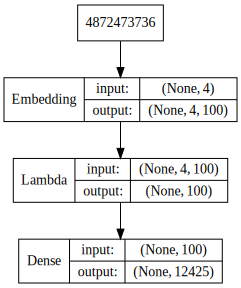

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

### 训练模型

提取word embedding非常耗时，使用AWS P2.x instance with GPU也得需要1.5个小时

In [ ]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

### 获取词向量
最后我们就可以获得词向量，每个单词对应一个100维的向量

In [ ]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

<img src="images/cbow_embedding.png" style="width:700px;">
<caption><center> **Figure 1**: Word Embedding </center></caption>